# 尝试用RNN来解决3中的任务

### 介绍

我们之前使用的做法是直接将五个字母的索引传进网络，然后输出一个概率分布，这个概率分布就是我们的预测结果。但是这样做有一个问题，就是我们的网络只能看到一个字母，而不能看到整个单词。所以我们可以使用RNN来解决这个问题。（让网络去找出单词字母之间的顺序等等相关属性）

### 导入相关库

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 定义网络

In [39]:
# Define the rnn model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        seq_len, batch_size, hid_dim = out.shape
        out = out.reshape(-1, hid_dim)
        out = self.classifier(out)
        out = out.reshape(seq_len, batch_size, -1) # y = y.view(seq_len, batch_size, out_dim)
        return out

# Define the lstm model
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        seq_len, batch_size, hid_dim = out.shape
        out = out.reshape(-1, hid_dim)
        out = self.classifier(out)
        out = out.reshape(seq_len, batch_size, -1) # y = y.view(seq_len, batch_size, out_dim)
        return out

### 网络参数

In [40]:
# 定义网络参数
input_size = 1
hidden_size = 10
output_size = 7
num_layers = 1

In [41]:
rnn = SimpleRNN(input_size, hidden_size, output_size, num_layers).to(device)
# rnn = SimpleLSTM(input_size, hidden_size, output_size, num_layers).to(device)

In [42]:
summary(rnn, (5, 100, 1))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleRNN                                [5, 100, 7]               --
├─RNN: 1-1                               [5, 100, 10]              130
├─Sequential: 1-2                        [500, 7]                  --
│    └─Linear: 2-1                       [500, 10]                 110
│    └─Tanh: 2-2                         [500, 10]                 --
│    └─Linear: 2-3                       [500, 7]                  77
│    └─Softmax: 2-4                      [500, 7]                  --
Total params: 317
Trainable params: 317
Non-trainable params: 0
Total mult-adds (M): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.00
Estimated Total Size (MB): 0.11

### 加载数据集

In [43]:
df = pd.read_excel("Problem_C_Data_Wordle_new.xlsx")
df.head()

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),normal_value
0,2022-12-31,560,manly,20380,1899,0,2,17,37,29,12,2,0.343806
1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1,0.491583
2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2,0.097901
3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1,0.187709
4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3,0.308737


In [44]:
# 构造输入输出数据
df_Word = df.loc[:, 'Word']
df_Distribution = df.iloc[:, 5:12]
print('df_Word.shape = \n', df_Word.shape)
print('df_Distribution.shape = \n', df_Distribution.shape)
print('df_Word.head() = \n', df_Word.head())
print('df_Distribution.head() = \n', df_Distribution.head())

df_Word.shape = 
 (359,)
df_Distribution.shape = 
 (359, 7)
df_Word.head() = 
 0    manly
1    molar
2    havoc
3    impel
4    condo
Name: Word, dtype: object
df_Distribution.head() = 
    1 try  2 tries  3 tries  4 tries  5 tries  6 tries  7 or more tries (X)
0      0        2       17       37       29       12                    2
1      0        4       21       38       26        9                    1
2      0        2       16       38       30       12                    2
3      0        3       21       40       25        9                    1
4      0        2       17       35       29       14                    3


### 转换数据格式

In [45]:
def word2vec(word):
    # 将单词转换为向量
    # 这里由于单词长度为5，所以将单词转换为长度为5的向量是很简单的
    # 而在自然语言处理中，单词的长度是不固定的，所以需要将单词转换为固定长度的向量
    # 还要做embedding
    vec = np.zeros(5)
    for i in range(len(word)):
        vec[i] = ord(word[i]) - ord('a')
    return vec

def vec2word(vec):
    # 将向量转换为单词
    word = ''
    for i in range(len(vec)):
        word += chr(int(vec[i]) + ord('a'))
    return word

In [46]:
# 将数据转换为numpy数组
Word = df_Word.values # 1D array (359,)
Word = np.array([word2vec(word) for word in Word])
print('shape of the Word is: ', Word.shape)
print('the preview of the Word is:\n', Word[:5])
print('the true Word is:\n', df_Word[:5])

shape of the Word is:  (359, 5)
the preview of the Word is:
 [[12.  0. 13. 11. 24.]
 [12. 14. 11.  0. 17.]
 [ 7.  0. 21. 14.  2.]
 [ 8. 12. 15.  4. 11.]
 [ 2. 14. 13.  3. 14.]]
the true Word is:
 0    manly
1    molar
2    havoc
3    impel
4    condo
Name: Word, dtype: object


In [47]:
# 对Word进行normalization
# 方法一
# mean = np.mean(Word, axis=0)
# std = np.std(Word, axis=0)
# Word = (Word - mean) / std
# 方法二
Word = Word / 26

In [48]:
Distribution = df_Distribution.values # 2D array (359,7)
# 将Distribution转换为float类型，并除于100
Distribution = Distribution.astype(np.float32)
Distribution = Distribution / 100
print('shape of the Distribution is: ', Distribution.shape)
print('the preview of the Distribution is:\n', Distribution[:5])

shape of the Distribution is:  (359, 7)
the preview of the Distribution is:
 [[0.   0.02 0.17 0.37 0.29 0.12 0.02]
 [0.   0.04 0.21 0.38 0.26 0.09 0.01]
 [0.   0.02 0.16 0.38 0.3  0.12 0.02]
 [0.   0.03 0.21 0.4  0.25 0.09 0.01]
 [0.   0.02 0.17 0.35 0.29 0.14 0.03]]


### 构造训练集和测试集

In [49]:
# 划分训练集和测试集
train_size = int(0.7 * len(Word))
print('train_size = ', train_size)

train_size =  251


In [50]:
# 先将数据打乱
indices = np.arange(len(Word))
np.random.shuffle(indices) # 后面我们只需要用indices[idx]来索引正确的df_Word和df_Distribution
Word = Word[indices]
Distribution = Distribution[indices]

In [51]:
test_indices = indices[train_size:]

In [52]:
# 分割数据
# 由于Word的维度是(359, 5), Distribution的维度是(359, 7)
Word = Word.T
Distribution = Distribution
# 我们需要将Distribution的维度转换为(5, 359, 7), 359是训练集的大小, 7是Distribution的维度, 5是Word的长度 
# 由于原来的Distribution的维度是(359, 7),需要先重复5次,然后再reshape
train_Word = Word[:,:train_size].reshape(5, -1, 1)
train_Distribution = np.tile(Distribution[:train_size], (5, 1)).reshape(5, -1, 7)
test_Word = Word[:,train_size:].reshape(5, -1, 1)
test_Distribution = np.tile(Distribution[train_size:], (5, 1)).reshape(5, -1, 7)

In [53]:
print('shape of the train_Word is: ', train_Word.shape)
print('shape of the train_Distribution is: ', train_Distribution.shape)
print('shape of the test_Word is: ', test_Word.shape)
print('shape of the test_Distribution is: ', test_Distribution.shape)

shape of the train_Word is:  (5, 251, 1)
shape of the train_Distribution is:  (5, 251, 7)
shape of the test_Word is:  (5, 108, 1)
shape of the test_Distribution is:  (5, 108, 7)


In [54]:
tmpa = np.array([[1,2,3,4,5],
                 [6,7,8,9,10]])
np.repeat(tmpa, 5, axis=0)
# 把5个一样的tmpa拼接在一起，代码如下：
np.tile(tmpa, (5,1)).reshape(5, -1, 5)


array([[[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10]],

       [[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10]],

       [[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10]],

       [[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10]],

       [[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10]]])

In [55]:
train_Word[:, 0, :], train_Distribution[:, 0, :]

(array([[0.42307692],
        [0.        ],
        [0.57692308],
        [0.69230769],
        [0.15384615]]),
 array([[0.  , 0.08, 0.31, 0.34, 0.19, 0.07, 0.01],
        [0.  , 0.08, 0.31, 0.34, 0.19, 0.07, 0.01],
        [0.  , 0.08, 0.31, 0.34, 0.19, 0.07, 0.01],
        [0.  , 0.08, 0.31, 0.34, 0.19, 0.07, 0.01],
        [0.  , 0.08, 0.31, 0.34, 0.19, 0.07, 0.01]], dtype=float32))

In [56]:
test_word = vec2word(train_Word[:, 0, :].reshape(-1)*26)
print(test_word)
df[df['Word'] == test_word]

laose


,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),normal_value


In [57]:
# 将数据转换为tensor
train_Word = torch.from_numpy(train_Word).float().to(device)
train_Distribution = torch.from_numpy(train_Distribution).float().to(device)
test_Word = torch.from_numpy(test_Word).float().to(device)
test_Distribution = torch.from_numpy(test_Distribution).float().to(device)

In [58]:
# 构造数据加载器
batch_size = 32
train_data = torch.utils.data.TensorDataset(train_Word, train_Distribution)
test_data = torch.utils.data.TensorDataset(test_Word, test_Distribution)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

### criterion和optimizer

In [59]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

### 开始训练

In [60]:
num_epochs = 500
train_loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    rnn.train()
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = rnn(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= train_size
    train_loss_list.append(train_loss)
    rnn.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            y_pred = rnn(x)
            loss = criterion(y_pred, y)
            test_loss += loss.item()
    test_loss /= (359 - train_size)
    test_loss_list.append(test_loss)
    if (epoch + 1) % 20 == 0:
        print('Epoch [{:4d}/{:4d}], Train Loss: {:.6f}, Test Loss: {:.6f}'.format(epoch + 1, num_epochs, train_loss_list[-1], test_loss_list[-1]))

Epoch [  20/ 500], Train Loss: 0.000040, Test Loss: 0.000094
Epoch [  40/ 500], Train Loss: 0.000027, Test Loss: 0.000064
Epoch [  60/ 500], Train Loss: 0.000019, Test Loss: 0.000044
Epoch [  80/ 500], Train Loss: 0.000014, Test Loss: 0.000036
Epoch [ 100/ 500], Train Loss: 0.000013, Test Loss: 0.000033
Epoch [ 120/ 500], Train Loss: 0.000012, Test Loss: 0.000031
Epoch [ 140/ 500], Train Loss: 0.000012, Test Loss: 0.000030
Epoch [ 160/ 500], Train Loss: 0.000012, Test Loss: 0.000029
Epoch [ 180/ 500], Train Loss: 0.000011, Test Loss: 0.000029
Epoch [ 200/ 500], Train Loss: 0.000011, Test Loss: 0.000029
Epoch [ 220/ 500], Train Loss: 0.000011, Test Loss: 0.000029
Epoch [ 240/ 500], Train Loss: 0.000011, Test Loss: 0.000028
Epoch [ 260/ 500], Train Loss: 0.000011, Test Loss: 0.000028
Epoch [ 280/ 500], Train Loss: 0.000011, Test Loss: 0.000028
Epoch [ 300/ 500], Train Loss: 0.000011, Test Loss: 0.000029
Epoch [ 320/ 500], Train Loss: 0.000011, Test Loss: 0.000028
Epoch [ 340/ 500], Train

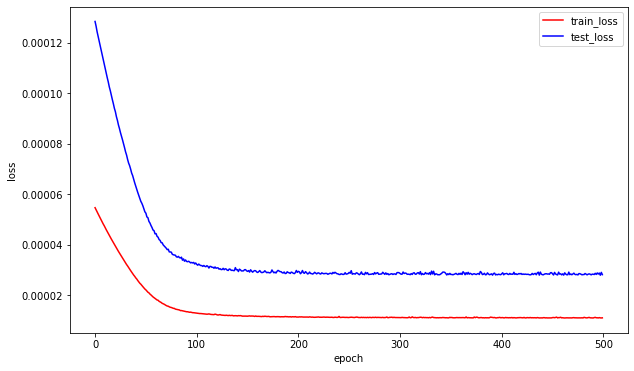

In [61]:
# 画图
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='train_loss', color='r')
plt.plot(test_loss_list, label='test_loss', color='b')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [62]:
min(test_loss_list)

2.7901061845046502e-05

### 模型评估

In [63]:
test_Word.shape

torch.Size([5, 108, 1])

In [64]:
test_Word[:, 0, :].T

tensor([[0.1923, 0.4231, 0.0000, 0.3077, 0.6538]])

In [65]:
test_Distribution[:, 0, :].view(5,-1,7)

tensor([[[0.0100, 0.0800, 0.3000, 0.3600, 0.1800, 0.0600, 0.0100]],

        [[0.0100, 0.0800, 0.3000, 0.3600, 0.1800, 0.0600, 0.0100]],

        [[0.0100, 0.0800, 0.3000, 0.3600, 0.1800, 0.0600, 0.0100]],

        [[0.0100, 0.0800, 0.3000, 0.3600, 0.1800, 0.0600, 0.0100]],

        [[0.0100, 0.0800, 0.3000, 0.3600, 0.1800, 0.0600, 0.0100]]])

In [66]:
def mseloss(y_pred, y):
    return np.mean((y_pred - y)**2)

In [67]:
tmpa = np.array([1,2,3,4,5])
tmpb = np.array([5,4,3,2,1])
mseloss(tmpa, tmpb)

8.0

In [68]:
(tmpa-tmpb)**2

array([16,  4,  0,  4, 16])

adore
word =  adore
output_np[-1][0] = 
 [0.01620454 0.06818175 0.2203451  0.33151504 0.21713986 0.11664227
 0.0299715 ]
test_Distribution[:,idx,:] = 
 [0.02 0.17 0.32 0.29 0.15 0.05 0.01]
criteria =  tensor(0.0068)
mse =  0.0044833957


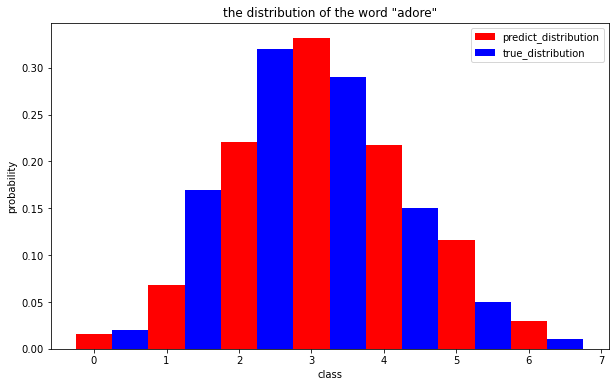

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),normal_value
27,2022-12-04,533,adore,25577,2398,2,17,32,29,15,5,1,0.506977


In [69]:
idx = np.random.randint(0, test_Word.shape[1])
print(vec2word(test_Word[:, idx, :].reshape(-1)*26))
# 找出该样本对应的单词
right_idx = test_indices[idx]
word = df['Word'][right_idx]
print('word = ', word)
# 推理
random_wordvec = test_Word[:,idx,:].unsqueeze(0).reshape(5,-1,1) # 由于模型的输入是(5, 1, 1)
rnn.eval()
with torch.no_grad():
    output = rnn(random_wordvec)
    output_np = output.cpu().numpy() # shape (5, 1, 7)
    print('output_np[-1][0] = \n', output_np[-1][0])
    print('test_Distribution[:,idx,:] = \n', test_Distribution[:,idx,:][0].cpu().numpy())
    print('criteria = ', criterion(output, test_Distribution[:,idx,:].view(5,-1,7)))
    print('mse = ', mseloss(output_np[-1][0], test_Distribution[:,idx,:][0].cpu().numpy()))
    # 画图
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(7), output_np[-1][0], width=0.5, label='predict_distribution', color='r')
    plt.bar(np.arange(7)+0.5,  test_Distribution[:,idx,:][0].cpu().numpy() , width=0.5, label='true_distribution', color='b')
    plt.xlabel('class')
    plt.ylabel('probability')
    plt.title('the distribution of the word "{}"'.format(word))
    plt.savefig('distribution_of_{}.png'.format(word))
    plt.legend()
    plt.show()
df[df['Word'] == word]

### 测试集总体的mse

In [70]:
with torch.no_grad():
    mse_sum = 0
    for idx in range(0, test_Word.shape[1]):
        random_wordvec = test_Word[:,idx,:].unsqueeze(0).reshape(5,-1,1) # 由于模型的输入是(5, 1, 1)
        output = rnn(random_wordvec)
        mse_sum += mseloss(output[-1][0].cpu().numpy(), test_Distribution[:,idx,:][0].cpu().numpy())
    print('mse_sum = ', mse_sum)

mse_sum =  0.6492024397157365


In [71]:
test_Word.shape[1]

108

### 预测单词eerie的分布

the distribution of the word eerie is: 
tensor([0.0258, 0.0726, 0.1899, 0.3693, 0.1832, 0.1201, 0.0391])


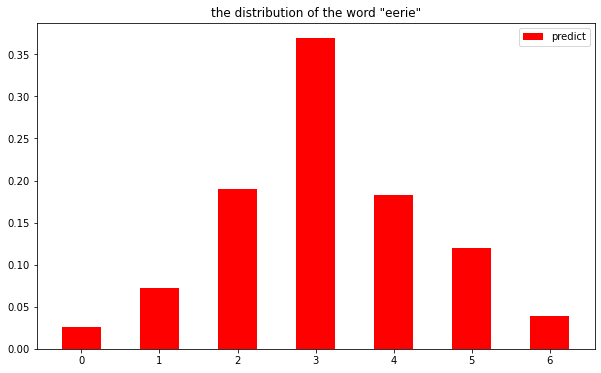

In [72]:
with torch.no_grad():
    # 预测单个单词
    word = 'eerie'
    vec = word2vec(word)
    vec = torch.from_numpy(vec).float()
    vec = vec.view(5,-1,1)
    output = rnn(vec)
    print('the distribution of the word {} is: \n{}'.format(word, output[-1][0]))
    # 画出预测的分布图
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(7), output[-1][0].numpy(), width=0.5, color='r',  label='predict')
    plt.title('the distribution of the word "{}"'.format(word))
    plt.legend()
    plt.show()